In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler

### EDA

**Dataset overview** 

We build a monthly U.S. macro–financial panel to nowcast recession risk. The target is the NBER recession indicator (**USRECM**, binary), taken from FRED. 

Predictors include: 

- the **10Y–3M Treasury yield spread (T10Y3M)**—a well-known leading recession signal (source: FRED; cross-checked with the New York Fed),

- the unemployment rate (**UNRATE**), 

- consumer prices (**CPIAUCSL**, used in level and YoY change), 

- industrial production (**INDPRO**), 

- housing starts (**HOUST**), 

- and consumer sentiment (**UMCSENT**). 

All series are sourced from **FRED** (Federal Reserve Economic Data), aligned to a monthly calendar, and merged on the month start. We engineer standard transformations (lags, month-over-month and year-over-year changes). The classification label is shifted **h months ahead** to avoid look-ahead bias. This dataset balances macro breadth (real, prices, labor, housing, sentiment) with a parsimonious set of robust leading indicators for recession nowcasting.

In [62]:
files = {
    "recession": "data/us_recession.csv",
    "unrate": "data/unrate.csv",
    "sentiment": "data/umcsent.csv",
    "indpro": "data/indpro.csv",
    "housing": "data/houst.csv",
    "cpi": "data/cpi.csv",
    "treasury_spread": "data/1030treasury_spreads.csv",
}


def load_series(path, series_name):
    data = pd.read_csv(path, parse_dates=["observation_date"])
    value_cols = [c for c in data.columns if c != "observation_date"]
    if len(value_cols) != 1:
        raise ValueError(f"{path} has {len(value_cols)} value columns, expected 1")
    series = data.rename(columns={value_cols[0]: series_name}).set_index("observation_date")
    if series_name == "treasury_spread":
        series = series.resample("MS").mean()  # resample to monthly data as it is in daily originally
    return series

raw_df = pd.concat(
    [load_series(path, name) for name, path in files.items()],
    axis=1,
    join="inner",
).sort_index()

raw_df["sentiment"] = raw_df["sentiment"].ffill().shift(1)  # shift by 1 month to avoid look-ahead (use info available by month-end)
raw_df["recession"] = raw_df["recession"].astype(int)

overview = pd.DataFrame(
    {
        "dtype": raw_df.dtypes.astype(str),
        "missing": raw_df.isna().sum(),
    }
)
overview["missing_pct"] = (overview["missing"] / len(raw_df) * 100).round(2)
duplicate_dates = raw_df.index.duplicated().sum()

df = raw_df.dropna().reset_index()
label_col = "recession"
date_col = "observation_date"
feature_cols = [c for c in df.columns if c not in {date_col, label_col}]

print(f"Shape before dropna: {raw_df.shape} | after dropna: {df.shape}")
print(f"Duplicate timestamps on observation_date: {duplicate_dates}")
print("Feature columns:", feature_cols)

overview


Shape before dropna: (524, 7) | after dropna: (523, 8)
Duplicate timestamps on observation_date: 0
Feature columns: ['unrate', 'sentiment', 'indpro', 'housing', 'cpi', 'treasury_spread']


,dtype,missing,missing_pct
recession,int64,0,0.00
unrate,float64,0,0.00
sentiment,float64,1,0.19
indpro,float64,0,0.00
housing,int64,0,0.00
cpi,float64,0,0.00
treasury_spread,float64,0,0.00


In [63]:
df.head()

,observation_date,recession,unrate,sentiment,indpro,housing,cpi,treasury_spread
0,1982-02-01,1,8.9,71.0,49.7839,866,94.7,0.146111
1,1982-03-01,1,9.0,66.5,49.4477,931,94.7,0.546522
2,1982-04-01,1,9.3,62.0,48.9913,917,95.0,0.527143
3,1982-05-01,1,9.4,65.5,48.6669,1025,95.9,0.908500
4,1982-06-01,1,9.6,67.5,48.5415,902,97.0,1.220909


In [64]:
df.describe()

,observation_date,recession,unrate,sentiment,indpro,housing,cpi,treasury_spread
count,523,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,2003-10-31 19:08:08.718929280,0.095602,5.965774,85.711855,84.036511,1372.040153,191.044226,1.557632
min,1982-02-01 00:00:00,0.000000,3.400000,50.000000,46.871300,478.000000,94.700000,-1.734545
25%,1992-12-16 12:00:00,0.000000,4.600000,76.000000,64.486700,1152.500000,142.550000,0.564795
50%,2003-11-01 00:00:00,0.000000,5.600000,89.500000,91.136900,1410.000000,185.100000,1.603000
75%,2014-09-16 00:00:00,0.000000,7.100000,94.950000,99.464400,1627.000000,236.693000,2.556750
max,2025-08-01 00:00:00,1.000000,14.800000,112.000000,104.211500,2273.000000,323.364000,4.146190
std,NaN,0.294327,1.824050,13.102428,18.048498,373.254292,60.082454,1.246901


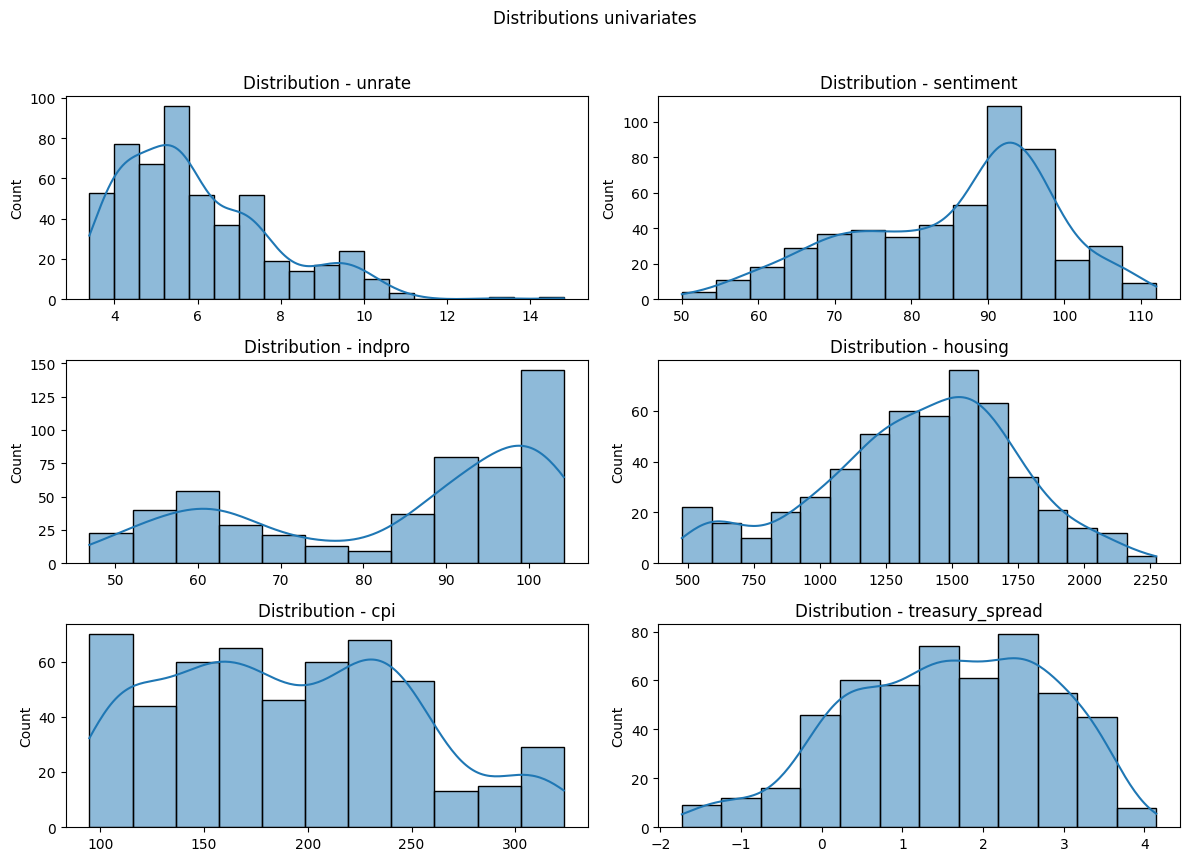

In [65]:
n_cols = 2
n_rows = int(np.ceil(len(feature_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, feature_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution - {col}")
    ax.set_xlabel("")
    ax.grid(False)

for ax in axes[len(feature_cols):]:
    ax.remove()

fig.suptitle("Distributions univariates", y=1.02)
plt.tight_layout()
plt.show()


unemployment is right-skewed with a few high spikes; sentiment is close to normal around ~90; industrial production is bimodal (lower early regime, higher recent plateau), indicating a structural break; housing is bimodal and skewed, showing clear boom/bust cycles; CPI is strictly rising (strong non-stationarity—diff/log needed); the yield spread is centered slightly above zero with fat tails and negative inversions that typically foreshadow recessions.

Share of recession months: 9.56% (523 total observations)


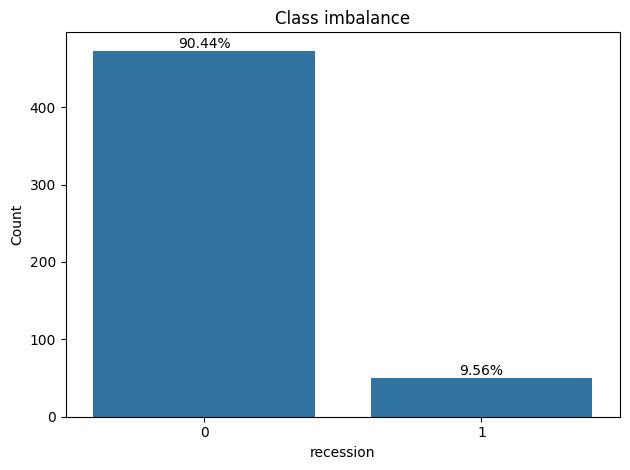

,count,pct
recession,,
0,473,90.44
1,50,9.56


In [66]:
class_balance = (
    df[label_col]
    .value_counts()
    .sort_index()
    .rename_axis(label_col)
    .to_frame("count")
)
class_balance["pct"] = (class_balance["count"] / len(df) * 100).round(2)
minority_pct = class_balance.loc[class_balance.index == 1, "pct"].iloc[0] if 1 in class_balance.index else 0.0
print(f"Share of recession months: {minority_pct:.2f}% ({class_balance['count'].sum()} total observations)")

display_df = class_balance.reset_index()
ax = sns.barplot(data=display_df, x=label_col, y="count")
ax.set_title("Class imbalance")
ax.set_ylabel("Count")
for idx, row in display_df.iterrows():
    ax.text(idx, row["count"], f"{row['pct']}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

class_balance


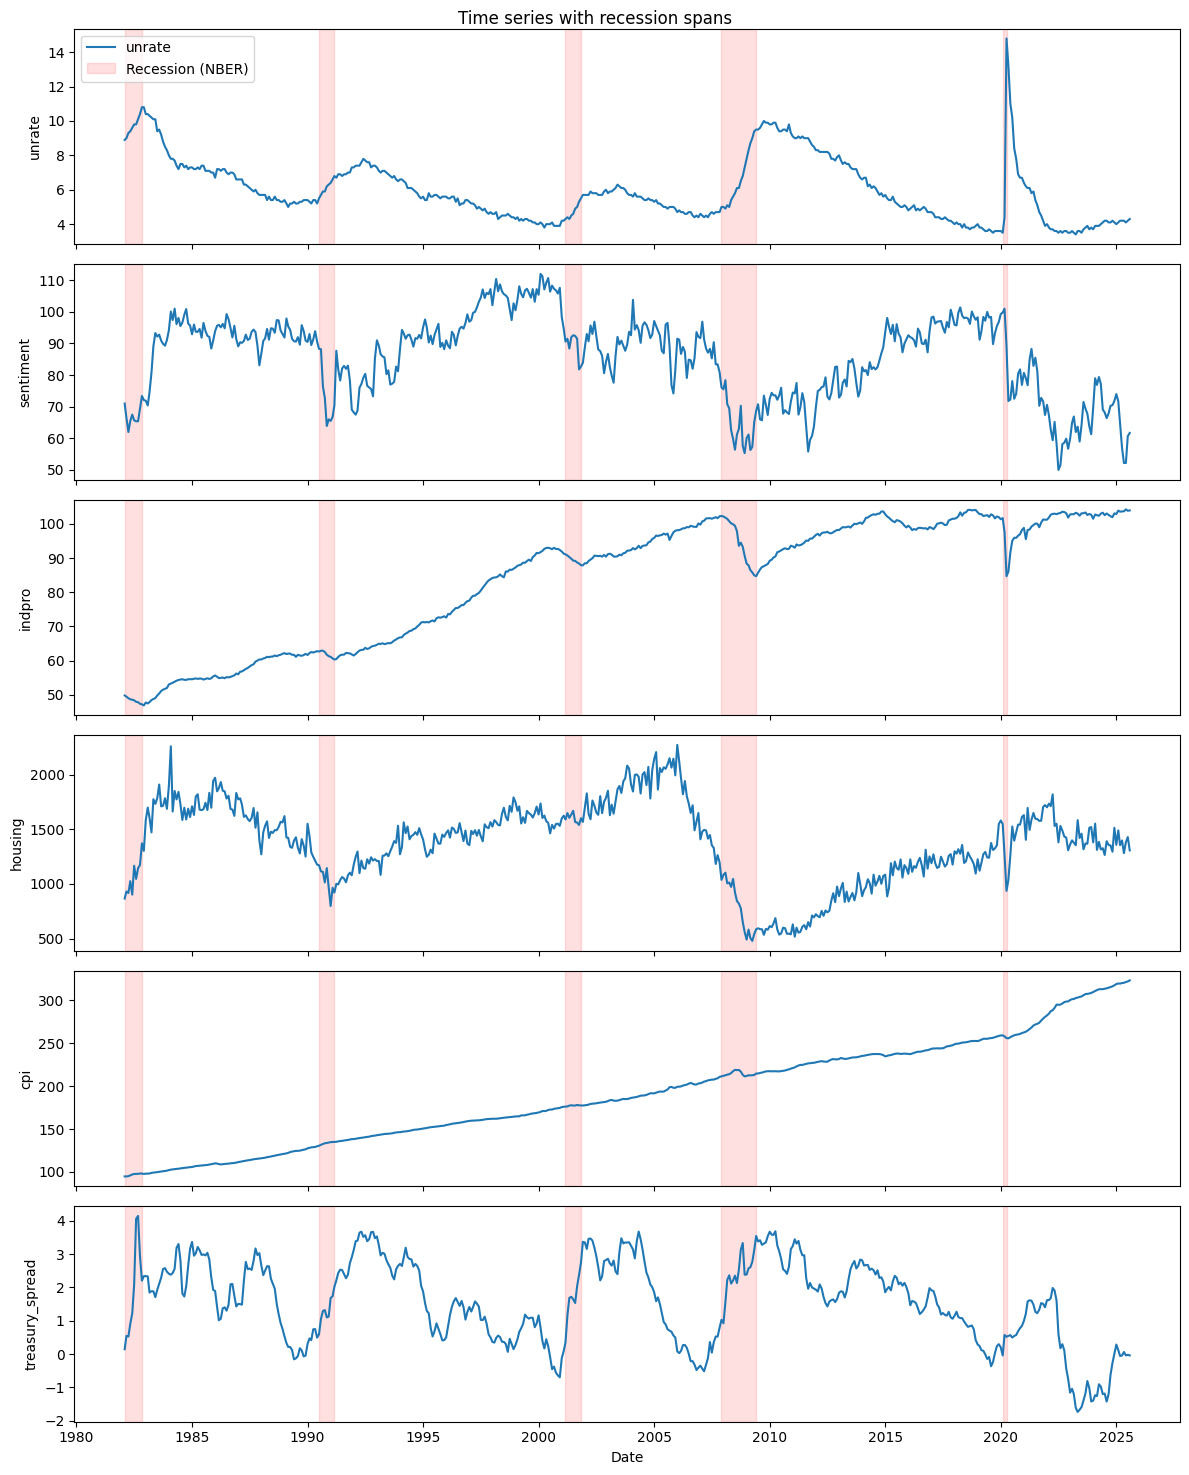

In [67]:
df_sorted = df.sort_values(date_col)
spans = []
start = None
prev_date = None
for date, flag in zip(df_sorted[date_col], df_sorted[label_col]):
    if flag and start is None:
        start = date
    if not flag and start is not None:
        spans.append((start, prev_date))
        start = None
    prev_date = date
if start is not None:
    spans.append((start, df_sorted[date_col].iloc[-1]))

fig, axes = plt.subplots(len(feature_cols), 1, figsize=(12, 2.5 * len(feature_cols)), sharex=True)
first_span = True
for ax, col in zip(axes, feature_cols):
    ax.plot(df_sorted[date_col], df_sorted[col], label=col, color="C0")
    for s, e in spans:
        label = "Recession (NBER)" if first_span else None
        ax.axvspan(s, e, color="red", alpha=0.12, label=label)
        first_span = False
    ax.set_ylabel(col)
    ax.grid(False)
axes[-1].set_xlabel("Date")
axes[0].legend(loc="upper left")
fig.suptitle("Time series with recession spans", y=0.98)
plt.tight_layout()
plt.show()


each recession shows a clear rise in unemployment and drop in sentiment; industrial production trends upward long term but snaps down during recessions; housing is highly cyclical with a major collapse in 2008 and slow recovery; CPI rises almost monotonically (supports differencing or YoY transforms); the spread flattens and turns negative before recessions (bond market leading signal) and rebounds afterward.

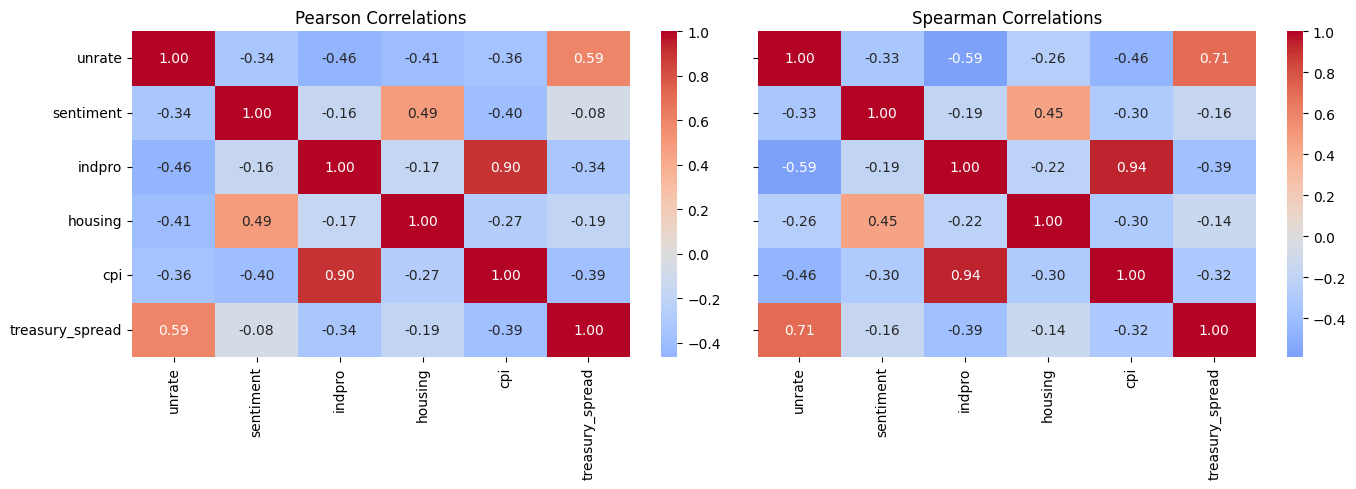

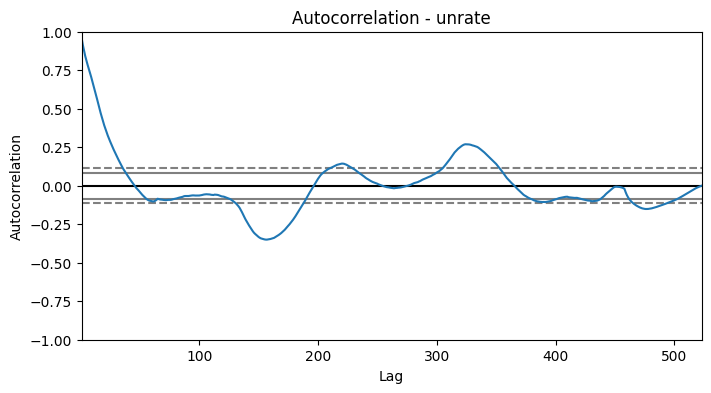

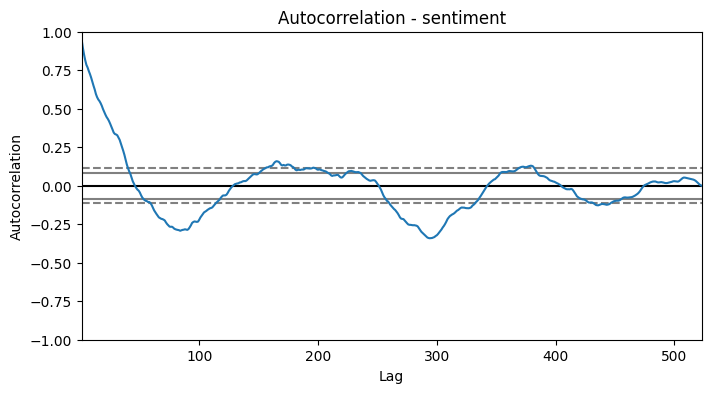

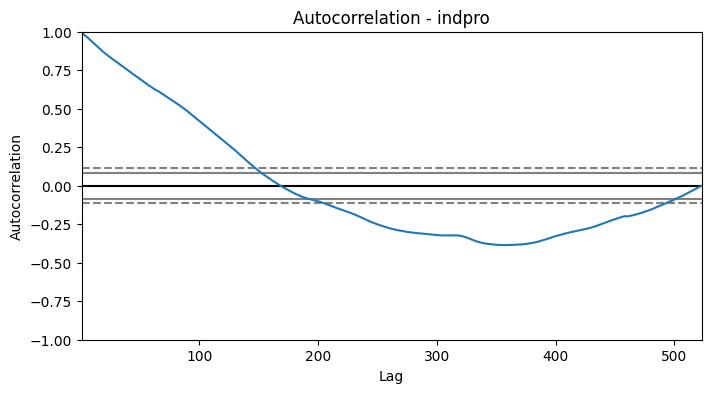

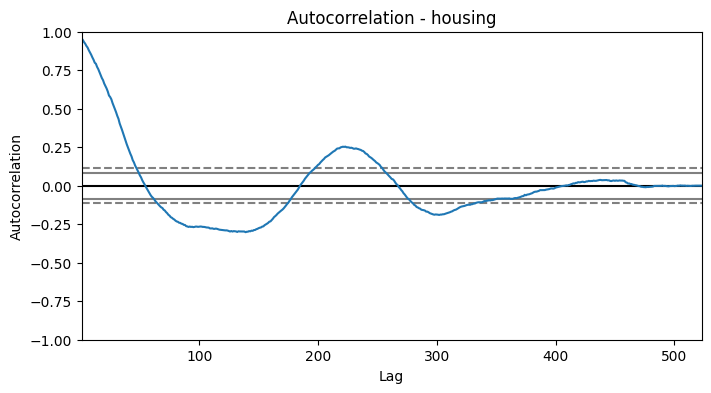

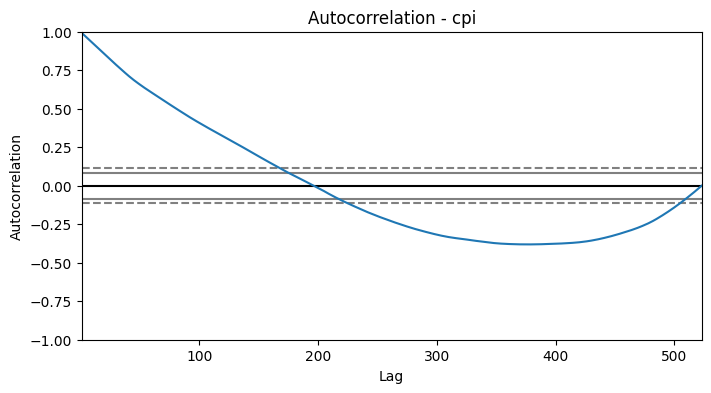

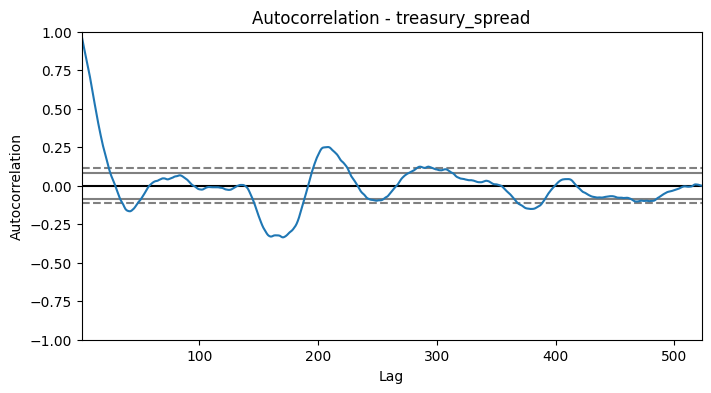

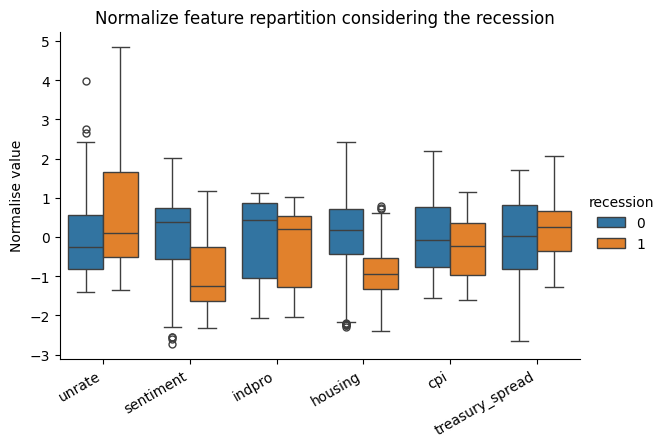

In [68]:
df_clean = df.copy()

# Normalised series
scaler = StandardScaler()
normalized = scaler.fit_transform(df_clean[feature_cols])
normalized_df = (pd.DataFrame(normalized, columns=feature_cols, index=df_clean[date_col]).sort_index())

# Correlations
pearson_corr = df_clean[feature_cols].corr(method="pearson")
spearman_corr = df_clean[feature_cols].corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
sns.heatmap(pearson_corr, ax=axes[0], cmap="coolwarm", center=0, annot=True, fmt=".2f")
axes[0].set_title("Pearson Correlations")
sns.heatmap(spearman_corr, ax=axes[1], cmap="coolwarm", center=0, annot=True, fmt=".2f")
axes[1].set_title("Spearman Correlations")
plt.tight_layout()
plt.show()

# Autocorrelation
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    autocorrelation_plot(df_clean.set_index(date_col)[col])
    plt.grid(False)
    plt.title(f"Autocorrelation - {col}")
    plt.show()

# Label distribution
plot_data = (normalized_df[feature_cols].assign(recession=df_clean[label_col].values).reset_index().melt(id_vars=[date_col, label_col], var_name="feature", value_name="value"))
g = sns.catplot(data=plot_data,x="feature",y="value",hue="recession",kind="box",height=4,aspect=1.5)
g.set_xticklabels(rotation=30, ha="right")
g.fig.suptitle("Normalize feature repartition considering the recession", y=1.02)
plt.xlabel("")
plt.ylabel("Normalise value")
plt.show()


Correlation matrices reveal a tight indpro–cpi block and strong inverse links with unemployment; the treasury spread mirrors unemployment, confirming its usefulness as an early-warning indicator.

Recession-band plots show spread/unemployment rising while sentiment and housing fall in each downturn; univariate histograms show heavier tails for the spread and unemployment versus tighter sentiment/housing distributions.

Autocorrelation show persistent dynamics, and the label remains clearly imbalanced (few recession months), so class weighting or threshold tuning will be required downstream.


### Feature Engineering

In [ ]:
H = 6
def compute_features(files, horizon=H):
    df = pd.concat([load_series(p, n) for n,p in files.items()], axis=1, join="inner").sort_index()
    df["sentiment"] = df["sentiment"].ffill().shift(1)
    df["target"] = df["recession"].shift(-horizon).astype(float)

    feats = []
    for col in ["indpro","cpi","housing","sentiment"]:
        s = df[col]
        block = pd.DataFrame(index=df.index)
        block[f"{col}_yoy"] = np.log(s).diff(12)   # YoY log change (stable)
        block[f"{col}_m1"] = np.log(s).diff(1)    # 1m log change
        for L in [3,6,12]:
            block[f"{col}_lag{L}"] = s.shift(L)
        feats.append(block)

    for col in ["unrate","treasury_spread"]:
        s = df[col]
        block = pd.DataFrame(index=df.index)
        block[f"{col}_d1"] = s.diff(1)
        block[f"{col}_d12"] = s.diff(12)
        for L in [3,6,12]:
            block[f"{col}_lag{L}"] = s.shift(L)
        feats.append(block)

    X = pd.concat(feats, axis=1).replace([np.inf,-np.inf], np.nan)
    data = pd.concat([X, df["target"]], axis=1).dropna()
    y = data.pop("target").astype(int)
    return data, y

X, y = compute_features(files)
X.head()

"""
Horizon: target = recession.shift(-6) pour prédire 6 mois à l’avance, cohérent avec l’idée que spread/unemployment se déforment plusieurs mois avant chaque récession sur les bandes temporelles.

Sentiment: ffill().shift(1) pour imputer la valeur la plus récente disponible et la décaler d’un mois, afin d’éviter tout leak lié au délai de publication.

Séries à tendance (indpro, cpi, housing, sentiment): log-diff YoY (diff(12)) pour enlever la tendance et capter les phases hautes/basses du cycle qu’on a vues sur les graphiques de récession; log-diff 1m (diff(1)) pour le momentum court terme; lags 3/6/12 pour exploiter l’autocorrélation mise en évidence et différentes échelles du cycle (trimestre, semestre, année).

Séries déjà en niveau/rate (unrate, treasury_spread): différences simple 1m et 12m plutôt que logs (séries peuvent être zéro ou négatives), pour suivre les pentes qui s’inversent avant les récessions (spread qui chute, chômage qui grimpe); lags 3/6/12 pour capturer la persistance signalée par l’autocorrélation.

Nettoyage: concat aligné sur l’intersection des dates, remplacement des inf, puis dropna pour ne garder que les observations où toutes les features et la cible sont connues avant le mois prédit.
"""


,indpro_yoy,indpro_m1,indpro_lag3,indpro_lag6,indpro_lag12,cpi_yoy,cpi_m1,cpi_lag3,cpi_lag6,cpi_lag12,...,unrate_d1,unrate_d12,unrate_lag3,unrate_lag6,unrate_lag12,treasury_spread_d1,treasury_spread_d12,treasury_spread_lag3,treasury_spread_lag6,treasury_spread_lag12
observation_date,,,,,,,,,,,,,,,,,,,,,
1983-02-01,-0.048049,-0.006123,47.2078,47.9382,49.7839,0.034253,0.001021,98.0,97.7,94.7,...,0.0,1.5,10.8,9.8,8.9,-0.009474,2.184415,2.204211,4.057727,0.146111
1983-03-01,-0.032999,0.008274,46.8713,47.8139,49.4477,0.035273,0.001020,97.7,97.7,94.7,...,-0.1,1.3,10.8,10.1,9.0,-0.483570,1.300435,2.337273,4.146190,0.546522
1983-04-01,-0.011145,0.012581,47.7398,47.3575,48.9913,0.039221,0.007110,97.9,98.1,95.0,...,-0.1,0.9,10.4,10.4,9.3,0.039543,1.359357,2.340000,2.939000,0.527143
1983-05-01,0.001645,0.006146,47.4484,47.2078,48.6669,0.033832,0.004040,98.0,98.0,95.9,...,-0.1,0.7,10.4,10.8,9.4,-0.002214,0.975786,2.330526,2.204211,0.908500
1983-06-01,0.010287,0.006062,47.8426,46.8713,48.5415,0.024441,0.002014,98.1,97.7,97.0,...,0.0,0.5,10.3,10.8,9.6,-0.175195,0.488182,1.846957,2.337273,1.220909


Classification report :
              precision    recall  f1-score   support

           0      1.000     0.408     0.580        98
           1      0.049     1.000     0.094         3

    accuracy                          0.426       101
   macro avg      0.525     0.704     0.337       101
weighted avg      0.972     0.426     0.565       101


Confusion matrix :
[[40 58]
 [ 0  3]]

ROC AUC : 0.667


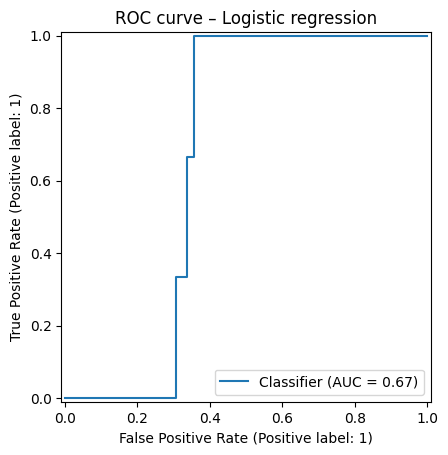

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


split_idx = int(len(X) * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs")),
    ]
)
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Classification report :")
print(classification_report(y_test, y_pred, digits=3))
print("\nConfusion matrix :")
print(confusion_matrix(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC : {auc:.3f}")
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve – Logistic regression")
plt.show()